# MultiModal

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
!tar -xvf /content/gdrive/My\ Drive/MultiModal/data/sunrgbd_lite.tar.gz

# Utils to load and work with RGB-D data

In [0]:
import torch
import os
import sys
sys.path.append('/content/gdrive/My Drive/MultiModal')
import RGBDutils

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import itertools

# Baseline, Monomodal
Let's see how RGBD and Depth monomodal learning work alone

# RGB monomodal

In [0]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to the dataset
data_dir = 'sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
rgb_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, 'rgb'),
                                          data_transforms[x])
                  for x in partitions}

hha_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, 'hha'),
                                          data_transforms[x])
                  for x in partitions}

rgb_dataloaders = {x: torch.utils.data.DataLoader(rgb_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                  for x in partitions}

hha_dataloaders = {x: torch.utils.data.DataLoader(hha_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                  for x in partitions}
rgb_dataset_sizes = {x: len(rgb_datasets[x]) for x in partitions}
hha_dataset_sizes = {x: len(hha_datasets[x]) for x in partitions}

class_names = rgb_datasets['train'].classes

cuda = torch.cuda.is_available()

Let's visualize some images

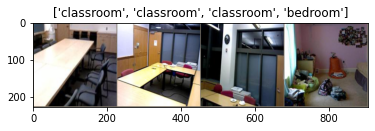

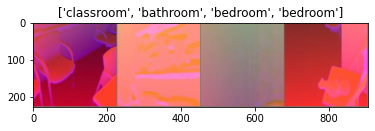

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
rgb_images, rgb_classes = next(iter(rgb_dataloaders['train']))
hha_images, hha_classes = next(iter(hha_dataloaders['train']))
rgb_images, rgb_classes = rgb_images[0:4], rgb_classes[0:4]
hha_images, hha_classes = hha_images[0:4], hha_classes[0:4]

# Make a grid from batch
rgb_out = torchvision.utils.make_grid(rgb_images)
hha_out = torchvision.utils.make_grid(hha_images)

imshow(rgb_out, title=[class_names[x] for x in rgb_classes])
imshow(hha_out, title=[class_names[x] for x in hha_classes])

# Training model utility

Breaking it into smaller pieces helps us be more familiar with the actual implementation

In [0]:
def monomodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc):
  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    print('Phase %s' % phase)
    if phase == 'train':
      if scheduler != None:
        scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
      if cuda:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs, labels = Variable(inputs), Variable(labels)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss.data * inputs.size(0)
      # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
      running_loss += loss.data.item() * inputs.size(0) # Pytorch 1
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / rgb_dataset_sizes[phase]
    epoch_acc = running_corrects / rgb_dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print()
  return best_model_wts, best_acc

def monomodal_train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        best_model_wts, best_acc = monomodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Evaluation model utility

In [0]:
def evaluate_monomodal_model(dataloaders, model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        if cuda:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs.size(0) # Pytorch 1
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / rgb_dataset_sizes[partition]
    test_acc = running_corrects / rgb_dataset_sizes[partition]
    
    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss

In [0]:
# Train For
def trainAndEvaluateMonoModal(dalaloaders, initialize_model):
  model, criterion, optimizer = initialize_model()
  model = monomodal_train_model(dalaloaders, model, criterion, optimizer, None, num_epochs=25)
    
  # Evaluate
  train_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'train', criterion)
  val_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'val', criterion)
  test_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'test', criterion)
  print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))
  return train_acc, val_acc, test_acc

In [0]:
def initialize_model_monomodal():
  model = models.alexnet(pretrained=True)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False
    
  num_classes = len(class_names)
  c = model.classifier
  num_ftrs = c[6].in_features
  model.classifier = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5],nn.Linear(num_ftrs, num_classes))

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate =0.001
  perlayer_optim = [
    {'params': model.features[0].parameters(), 'lr': 0.00}, # conv1
    {'params': model.features[3].parameters(), 'lr': 0.00}, # conv2
    {'params': model.features[6].parameters(), 'lr': 0.00}, # conv3
    {'params': model.features[8].parameters(), 'lr': 0.00}, # conv4
    {'params': model.features[10].parameters(), 'lr': 0.00}, # conv5
    {'params': model.classifier[1].parameters(), 'lr': 0.000}, # fc6
    {'params': model.classifier[4].parameters(), 'lr': 0.000}, # fc7
    {'params': model.classifier[6].parameters(), 'lr': 0.001} # fc8
  ]
  for param in itertools.chain(model.features[0].parameters(),model.features[3].parameters(),
                             model.features[6].parameters(),model.features[8].parameters(),
                             model.features[10].parameters(),model.classifier[1].parameters(),
                             model.classifier[4].parameters(),model.classifier[6].parameters()):
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(perlayer_optim, lr=learning_rate)

  return model, criterion, optimizer


Train And evaluate RGB 5 runs


In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMonoModal(rgb_dataloaders, initialize_model_monomodal), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 1.7212 Acc: 0.7087
Phase val
val Loss: 1.5602 Acc: 0.7823

Epoch 1/24
----------
Phase train
train Loss: 1.1821 Acc: 0.7852
Phase val
val Loss: 1.4525 Acc: 0.7776

Epoch 2/24
----------
Phase train
train Loss: 0.9809 Acc: 0.8201
Phase val
val Loss: 1.5729 Acc: 0.7512

Epoch 3/24
----------
Phase train
train Loss: 0.7607 Acc: 0.8698
Phase val
val Loss: 1.6485 Acc: 0.7316

Epoch 4/24
----------
Phase train
train Loss: 0.6383 Acc: 0.8966
Phase val
val Loss: 1.9464 Acc: 0.7212

Epoch 5/24
----------
Phase train
train Loss: 0.5240 Acc: 0.9060
Phase val
val Loss: 1.9131 Acc: 0.7362

Epoch 6/24
----------
Phase train
train Loss: 0.6439 Acc: 0.9007
Phase val
val Loss: 1.9857 Acc: 0.7408

Epoch 7/24
----------
Phase train
train Loss: 0.6109 Acc: 0.8953
Phase val
val Loss: 2.1896 Acc: 0.7258

Epoch 8/24
----------
Phase train
train Loss: 0.6200 Acc: 0.8913
Phase val
val Loss: 2.2344 Acc: 0.7166

Epoch 9/24
----------
Phase train
train Loss: 0.6905 Ac

In [0]:
print('Mean training RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB accuracy 89.42282795906067%
StDev training RGB accuracy 4.38365638256073%
Mean validation RGB accuracy 78.22580933570862%
StDev validation RGB accuracy 0.8465987630188465%
Mean test RGB accuracy 72.4133551120758%
StDev test RGB accuracy 0.7944502867758274%


Train And evaluate HHA 5 runs


In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMonoModal(hha_dataloaders, initialize_model_monomodal), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 2.4979 Acc: 0.5195
Phase val
val Loss: 2.4695 Acc: 0.5714

Epoch 1/24
----------
Phase train
train Loss: 1.7633 Acc: 0.6685
Phase val
val Loss: 2.4950 Acc: 0.6348

Epoch 2/24
----------
Phase train
train Loss: 1.5934 Acc: 0.7208
Phase val
val Loss: 2.4600 Acc: 0.6198

Epoch 3/24
----------
Phase train
train Loss: 1.7174 Acc: 0.6872
Phase val
val Loss: 2.6625 Acc: 0.6106

Epoch 4/24
----------
Phase train
train Loss: 1.5452 Acc: 0.7114
Phase val
val Loss: 2.8725 Acc: 0.6002

Epoch 5/24
----------
Phase train
train Loss: 1.4563 Acc: 0.7181
Phase val
val Loss: 3.6836 Acc: 0.5000

Epoch 6/24
----------
Phase train
train Loss: 1.4405 Acc: 0.7302
Phase val
val Loss: 3.1893 Acc: 0.5530

Epoch 7/24
----------
Phase train
train Loss: 1.2946 Acc: 0.7745
Phase val
val Loss: 3.2670 Acc: 0.5910

Epoch 8/24
----------
Phase train
train Loss: 1.2894 Acc: 0.7664
Phase val
val Loss: 3.5452 Acc: 0.5346

Epoch 9/24
----------
Phase train
train Loss: 1.3093 Ac

In [0]:
print('Mean training HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training HHA accuracy 80.51007390022278%
StDev training HHA accuracy 1.4391862787306309%
Mean validation HHA accuracy 65.27649164199829%
StDev validation HHA accuracy 1.5224814414978027%
Mean test HHA accuracy 63.02458047866821%
StDev test HHA accuracy 0.7864125072956085%


# Baseline, multimodal

In [0]:
# Data augmentation and normalization for training
RGB_AVG = [0.485, 0.456, 0.406] # Default ImageNet ILSRVC2012
RGB_STD = [0.229, 0.224, 0.225] # Default ImageNet ILSRVC2012
DEPTH_AVG = [0.485, 0.456, 0.406] # Default ImageNet ILSRVC2012
DEPTH_STD = [0.229, 0.224, 0.225] # Default ImageNet ILSRVC2012
data_transforms = {
    'train': RGBDutils.Compose([
        RGBDutils.RandomResizedCrop(227),
        RGBDutils.RandomHorizontalFlip(),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
    'val': RGBDutils.Compose([
        RGBDutils.Resize(256),
        RGBDutils.CenterCrop(227),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
    'test': RGBDutils.Compose([
        RGBDutils.Resize(256),
        RGBDutils.CenterCrop(227),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
}

# Path to the dataset
# data_dir = '/home/mcv/datasets/sunrgbd_lite'
data_dir = 'sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
multimodal_datasets = {x: RGBDutils.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in partitions}

multimodal_dataloaders = {x: torch.utils.data.DataLoader(multimodal_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
                    for x in partitions}

dataset_sizes = {x: len(multimodal_datasets[x]) for x in partitions}
class_names = multimodal_datasets['train'].classes

cuda = torch.cuda.is_available()

Let's visualize some images

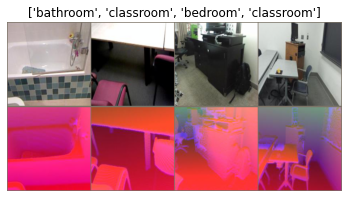

In [0]:
# Get a batch of training data and visualize the first four pairs
inputsRGB, inputsDepth, classes = next(iter(multimodal_dataloaders['train']))
inputsRGB, inputsDepth, classes = inputsRGB[0:4], inputsDepth[0:4], classes[0:4]

# Make a grid from batch
outRGB = torchvision.utils.make_grid(inputsRGB)
outDepth = torchvision.utils.make_grid(inputsDepth)

RGBDutils.imshow(outRGB, outDepth, title=[class_names[x] for x in classes],concat_vert=True)

# Training multimodal utility

In [0]:
def multimodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc):
  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    print('Phase %s' % phase)
    if phase == 'train':
      if scheduler != None:
        scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for inputs_rgb, inputs_hha, labels in dataloaders[phase]:
      if cuda:
        inputs_rgb = Variable(inputs_rgb.cuda())
        inputs_hha = Variable(inputs_hha.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = model((inputs_rgb, inputs_hha))
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss.data * inputs_rgb.size(0)
      # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
      running_loss += loss.data.item() * inputs_rgb.size(0) # Pytorch 1
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print()
  return best_model_wts, best_acc

def multimodal_train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        best_model_wts, best_acc = multimodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Evaluation multimodal utility

In [0]:
def evaluate_multimodal_model(dataloaders, model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs_rgb, inputs_hha, labels = data
        # wrap them in Variable
        if cuda:
            inputs_rgb = Variable(inputs_rgb.cuda())
            inputs_hha = Variable(inputs_hha.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

        # forward
        outputs = model((inputs_rgb, inputs_hha))
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs_rgb.size(0) # Pytorch 1
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[partition]
    test_acc = running_corrects / dataset_sizes[partition]
    
    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss

In [0]:
# Train For
def trainAndEvaluateMultiModal(dalaloaders, initialize_model, num_epochs=25):
  model, criterion, optimizer = initialize_model()
  model = multimodal_train_model(dalaloaders, model, criterion, optimizer, None, num_epochs=num_epochs)
    
  # Evaluate
  train_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'train', criterion)
  val_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'val', criterion)
  test_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'test', criterion)
  print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))
  return train_acc, val_acc, test_acc

# Baseline class to implement MultiModal network with two branches

In [0]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(RGBDnet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features

        # Classifier
        self.classifier = nn.Linear(num_ftrs_rgb+num_ftrs_hha, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.rgb_convs(x[0])
        x_rgb = x_rgb.view(x_rgb.size(0), 256 * 6 * 6)
        x_hha = self.hha_convs(x[1])
        x_hha = x_hha.view(x_hha.size(0), 256 * 6 * 6)
        x_rgb = self.rgb_fcs(x_rgb)
        x_hha = self.hha_fcs(x_hha)
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x

In [0]:
import torchvision.models
def initialize_model_rgbd():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=models.alexnet(pretrained=True),
                hha_branch=models.alexnet(pretrained=True), 
                num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001
    
  perlayer_optim = [
    {'params': model.rgb_convs[0].parameters(), 'lr': 0.00}, # conv1 RGB
    {'params': model.rgb_convs[3].parameters(), 'lr': 0.00}, # conv2 RGB
    {'params': model.rgb_convs[6].parameters(), 'lr': 0.00}, # conv3 RGB
    {'params': model.rgb_convs[8].parameters(), 'lr': 0.00}, # conv4 RGB
    {'params': model.rgb_convs[10].parameters(), 'lr': 0.00}, # conv5 RGB
    {'params': model.rgb_fcs[1].parameters(), 'lr': 0.00}, # fc6 RGB
    {'params': model.rgb_fcs[4].parameters(), 'lr': 0.00}, # fc7 RGB
    {'params': model.hha_convs[0].parameters(), 'lr': 0.00}, # conv1 HHA
    {'params': model.hha_convs[3].parameters(), 'lr': 0.00}, # conv2 HHA
    {'params': model.hha_convs[6].parameters(), 'lr': 0.00}, # conv3 HHA
    {'params': model.hha_convs[8].parameters(), 'lr': 0.00}, # conv4 HHA
    {'params': model.hha_convs[10].parameters(), 'lr': 0.00}, # conv5 HHA
    {'params': model.hha_fcs[1].parameters(), 'lr': 0.00}, # fc6 HHA
    {'params': model.hha_fcs[4].parameters(), 'lr': 0.00}, # fc7 HHA
    {'params': model.classifier.parameters(), 'lr': 0.001} # fc8
  ]
  for param in itertools.chain(model.rgb_convs[0].parameters(),model.rgb_convs[3].parameters(),
                             model.rgb_convs[6].parameters(),model.rgb_convs[8].parameters(),
                             model.rgb_convs[10].parameters(),model.rgb_fcs[1].parameters(),
                             model.rgb_fcs[4].parameters(),
                             model.hha_convs[0].parameters(),model.hha_convs[3].parameters(),
                             model.hha_convs[6].parameters(),model.hha_convs[8].parameters(),
                             model.hha_convs[10].parameters(),model.hha_fcs[1].parameters(),
                             model.hha_fcs[4].parameters(),
                             model.classifier.parameters()):
    param.requires_grad = True
    
    
  optimizer = torch.optim.Adam(perlayer_optim, lr=learning_rate)

  return model, criterion, optimizer

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_rgbd), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 2.0186 Acc: 0.6349
Phase val
val Loss: 1.6908 Acc: 0.6578

Epoch 1/24
----------
Phase train
train Loss: 1.0301 Acc: 0.8242
Phase val
val Loss: 1.3160 Acc: 0.7707

Epoch 2/24
----------
Phase train
train Loss: 0.7549 Acc: 0.8658
Phase val
val Loss: 1.2759 Acc: 0.7788

Epoch 3/24
----------
Phase train
train Loss: 0.7309 Acc: 0.8779
Phase val
val Loss: 1.4108 Acc: 0.7604

Epoch 4/24
----------
Phase train
train Loss: 0.6825 Acc: 0.8671
Phase val
val Loss: 1.1384 Acc: 0.8041

Epoch 5/24
----------
Phase train
train Loss: 0.5525 Acc: 0.9128
Phase val
val Loss: 1.1538 Acc: 0.8191

Epoch 6/24
----------
Phase train
train Loss: 0.4844 Acc: 0.9221
Phase val
val Loss: 1.1115 Acc: 0.8191

Epoch 7/24
----------
Phase train
train Loss: 0.4061 Acc: 0.9409
Phase val
val Loss: 1.1821 Acc: 0.7972

Epoch 8/24
----------
Phase train
train Loss: 0.4625 Acc: 0.9356
Phase val
val Loss: 1.2318 Acc: 0.7892

Epoch 9/24
----------
Phase train
train Loss: 0.3866 Ac

In [0]:
print('Mean training RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D accuracy 93.15436482429504%
StDev training RGB-D accuracy 2.3936308920383453%
Mean validation RGB-D accuracy 81.3364028930664%
StDev validation RGB-D accuracy 0.48332209698855877%
Mean test RGB-D accuracy 75.66477656364441%
StDev test RGB-D accuracy 0.5902991630136967%


# The results of the training of 5 consecutive runs are


Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB | 89.42 % / 4.38 % | 70.22 % / 0.84 % | 72.41 % / 0.79 %
HHA |  80.51 % / 1.49 % | 65.27 % / 1.52 % | 63.02 % / 0.79 %
RGB-D | 93.15 % / 2.39 % | 81.3% / 0.48 % | 75.66 % / 0.59 %

The results are more or less expected, the model that uses only RGB information outperforms from HHA that uses only depth info. This might be due to the fact that RGB info is more important for the task or that the pretrained AlexNet models they are based on have been trained on an RGB domain.

But the combination of those with the multimodal deep learning approach outperforms them proving the use of multiple modalities to solve a classification task.

# So far we have seen how monomodal with RGB and HHA works and compared with multimodal scheme, but the multimodal was made by just concatenating the output of the two branches before a classification layer.

Next, we pretend to test some different approaches:
*   Fine tune all layers
*   Use AlexNet pretrained on a different dataset (Places365)
*   Use different architectures instead of AlexNet

*   Align to joint space
*   Destillation from RGB (domain closer to where pretrained model is trained) to HHA 
*   Fusion at different layers
*   Depth-wise convolutions






# Let's fine tune some layers

In [0]:
import torchvision.models
def initialize_model_rgbd_finetune():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=models.alexnet(pretrained=True),
                  hha_branch=models.alexnet(pretrained=True), 
                  num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.rgb_convs[10:].parameters():
    param.requires_grad = True

  for param in model.hha_convs[10:].parameters():
    param.requires_grad = True
    
  for param in model.rgb_fcs.parameters():
    param.requires_grad = True

  for param in model.hha_fcs.parameters():
    param.requires_grad = True

  for param in model.classifier.parameters():
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_rgbd_finetune, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 4.6204 Acc: 0.4349
Phase val
val Loss: 1.5968 Acc: 0.7154

Epoch 1/34
----------
Phase train
train Loss: 1.4885 Acc: 0.7289
Phase val
val Loss: 1.4146 Acc: 0.7684

Epoch 2/34
----------
Phase train
train Loss: 1.0407 Acc: 0.8242
Phase val
val Loss: 1.6138 Acc: 0.7247

Epoch 3/34
----------
Phase train
train Loss: 0.9025 Acc: 0.8376
Phase val
val Loss: 1.6388 Acc: 0.7224

Epoch 4/34
----------
Phase train
train Loss: 0.8712 Acc: 0.8470
Phase val
val Loss: 1.3486 Acc: 0.7684

Epoch 5/34
----------
Phase train
train Loss: 0.6118 Acc: 0.8899
Phase val
val Loss: 1.9469 Acc: 0.6924

Epoch 6/34
----------
Phase train
train Loss: 0.7180 Acc: 0.8752
Phase val
val Loss: 1.3985 Acc: 0.8018

Epoch 7/34
----------
Phase train
train Loss: 0.6426 Acc: 0.8765
Phase val
val Loss: 1.9542 Acc: 0.7730

Epoch 8/34
----------
Phase train
train Loss: 0.6933 Acc: 0.8752
Phase val
val Loss: 1.4284 Acc: 0.7500

Epoch 9/34
----------
Phase train
train Loss: 0.5074 Ac

In [0]:
print('Mean training RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with fine tuned layers accuracy 94.49664950370789%
StDev training RGB-D with fine tuned layers accuracy 1.0257701389491558%
Mean validation RGB-D with fine tuned layers accuracy 81.17511868476868%
StDev validation RGB-D with fine tuned layers accuracy 0.5334476474672556%
Mean test RGB-D with fine tuned layers accuracy 75.05985498428345%
StDev test RGB-D with fine tuned layers accuracy 1.0326278395950794%


With some fine tuning of layers we reached no improvement with respect to RGBD training, and we needed to add 10 more epochs to the training because we observed that the training was slower. Maybe playing with a different learning rate scheduler could help to address this.

Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB-D | 93.15 % / 2.39 % | 81.3% / 0.48 % | 75.66 % / 0.59 %
RGB-D-finetuned | 94.50 % / 1.03 % | 81.18% / 0.53 % | 75.06 % / 1.03 %

# Let's try AlexNet trained on Places365

In [0]:
# load the pre-trained weights
branch_model_file = '/content/gdrive/My Drive/MultiModal/models/alexnet_places365.pth.tar'
rgb_branch = models.__dict__['alexnet'](num_classes=365)
hha_branch = models.__dict__['alexnet'](num_classes=365)

checkpoint = torch.load(branch_model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
rgb_branch.load_state_dict(state_dict)
rgb_branch.eval()
hha_branch.load_state_dict(state_dict)
hha_branch.eval()

In [0]:
# Instantiate the model
def initialize_model_alexnet_places365():
  branch_model_file = '/content/gdrive/My Drive/MultiModal/models/alexnet_places365.pth.tar'
  rgb_branch = models.__dict__['alexnet'](num_classes=365)
  hha_branch = models.__dict__['alexnet'](num_classes=365)

  checkpoint = torch.load(branch_model_file, map_location=lambda storage, loc: storage)
  state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  rgb_branch.load_state_dict(state_dict)
  rgb_branch.eval()
  hha_branch.load_state_dict(state_dict)
  hha_branch.eval()
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=rgb_branch,
                  hha_branch=hha_branch, 
                  num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()
    
  for param in model.classifier.parameters():
    param.requires_grad = True
    
  learning_rate = 0.001
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_alexnet_places365), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 1.9796 Acc: 0.6376
Phase val
val Loss: 1.2717 Acc: 0.7961

Epoch 1/24
----------
Phase train
train Loss: 1.1069 Acc: 0.7919
Phase val
val Loss: 1.2528 Acc: 0.7846

Epoch 2/24
----------
Phase train
train Loss: 0.8078 Acc: 0.8577
Phase val
val Loss: 1.1701 Acc: 0.8111

Epoch 3/24
----------
Phase train
train Loss: 0.7214 Acc: 0.8685
Phase val
val Loss: 1.1849 Acc: 0.7949

Epoch 4/24
----------
Phase train
train Loss: 0.6703 Acc: 0.8765
Phase val
val Loss: 1.3878 Acc: 0.7500

Epoch 5/24
----------
Phase train
train Loss: 0.6236 Acc: 0.8953
Phase val
val Loss: 1.2270 Acc: 0.7972

Epoch 6/24
----------
Phase train
train Loss: 0.5483 Acc: 0.8993
Phase val
val Loss: 1.2442 Acc: 0.7995

Epoch 7/24
----------
Phase train
train Loss: 0.5053 Acc: 0.9195
Phase val
val Loss: 1.3262 Acc: 0.7730

Epoch 8/24
----------
Phase train
train Loss: 0.4828 Acc: 0.9208
Phase val
val Loss: 1.2307 Acc: 0.7972

Epoch 9/24
----------
Phase train
train Loss: 0.4735 Ac

In [0]:
print('Mean training RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with AlexNet Places365 accuracy 87.94631958007812%
StDev training RGB-D with AlexNet Places365 accuracy 3.3523738384246826%
Mean validation RGB-D with AlexNet Places365 accuracy 80.92166185379028%
StDev validation RGB-D with AlexNet Places365 accuracy 0.2481653355062008%
Mean test RGB-D with AlexNet Places365 accuracy 76.42091512680054%
StDev test RGB-D with AlexNet Places365 accuracy 0.9160803630948067%


Opposito to what was expected, could not manage to see a boost in performance when using AlexNet trained on Places365

# Let's fusion at different layers

We try to build an architecture that does not only concatenate features coming from different modalities at the last stage of the network, but that also merges outputs from inner layers.

Our idea is based on having a 'fusion branch' that has 2 convolutional layers in its convolutional part and a couple fully connected layers (kind of mimicking the AlexNet architecture).

The first of the convolutional layers will get the output feature maps of the penultimate convolutionals of both RGB and HHA branches. (That would mean input of 512 feature maps) (This corresponds to the layer idx 10 of the features part of AlexNet)

After the firts conv layer, the last feature maps of the RGB and HHA layers are reinjected again. (Thus having 512 + 256) input channels at that stage.

At the last step in the classifiers, the feature vectors of the three branches is concatenated again to be connected to the output classification layer.

In [0]:
FIRST_CONV_LAYER_IDX_OUT = 10

# In PyTorch every network is implementd as a nn.Module
class RGBDFusionNet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(RGBDFusionNet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features
        
        #Branch to fusion features from the RGB and HHA branch
        self.fusion_features = nn.Sequential(
            #First convolution of features will receive as input the concatenated feature maps
            #from the output of the penultimate convolutional layers of both RGB and HHA branches
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Second convolution of features will receive as input the concatenated feature maps
            #from the output of the last convolutional layers of both RGB and HHA branches plus the result
            #of the convolution of its previous layer
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.fusion_fcs = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096)
        )

        self.rgb_avgpool = rgb_branch.avgpool
        self.hha_avgpool = rgb_branch.avgpool
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        num_ftrs_fusion = 4096

        self.classifier = nn.Linear(num_ftrs_rgb+num_ftrs_hha+num_ftrs_fusion, num_classes)

    def forward_branch_conv(self, branch_convs, first_layer, last_layer, x):
      for layer in branch_convs[first_layer:last_layer]:
        x = layer(x)
      return x

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
      x_rgb = x[0]
      #Extract first feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_rgb)
      
      x_hha = x[1]
      #Extract first feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_hha)
      
      #Concatenate first extracted feature maps and pass them as input to fusion_features branch
      x_fusion = torch.cat((x_rgb, x_hha), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 0, 3, x_fusion)

      #Extract second feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 10, len(self.rgb_convs), x_rgb)
      #Extract second feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 10, len(self.hha_convs), x_hha)

      #Reinject to fusion_features the second extracted feature maps from the branches
      x_fusion = torch.cat((x_fusion, torch.cat((x_rgb, x_hha), 1)), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 3, len(self.fusion_features), x_fusion)
      x_fusion = self.avgpool(x_fusion)
      x_fusion = torch.flatten(x_fusion, 1)
      x_rgb = self.rgb_avgpool(x_rgb)
      x_rgb = torch.flatten(x_rgb, 1)
      x_hha = self.rgb_avgpool(x_hha)
      x_hha = torch.flatten(x_hha, 1)
      #Pass three branches to their respectives Fully Connected parts
      x_rgb = self.rgb_fcs(x_rgb)
      x_hha = self.hha_fcs(x_hha)
      x_fusion = self.fusion_fcs(x_fusion)

      #Join the 3 feature vectors to pass to classifier
      x = torch.cat((x_rgb, x_hha), 1)
      x = torch.cat((x, x_fusion), 1)
      x = self.classifier(x)
      return x

In [0]:
import torchvision.models

def initialize_model_fusion():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDFusionNet(rgb_branch=models.alexnet(pretrained=True),
                      hha_branch=models.alexnet(pretrained=True), 
                      num_classes=num_classes)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.fusion_features.parameters():
    param.requires_grad = True

  for param in model.fusion_fcs.parameters():
    param.requires_grad = True

  for param in model.classifier.parameters():
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_fusion, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 13.6952 Acc: 0.4685
Phase val
val Loss: 1.7739 Acc: 0.6624

Epoch 1/34
----------
Phase train
train Loss: 1.2717 Acc: 0.7732
Phase val
val Loss: 1.5209 Acc: 0.7581

Epoch 2/34
----------
Phase train
train Loss: 1.0486 Acc: 0.8094
Phase val
val Loss: 1.1540 Acc: 0.7776

Epoch 3/34
----------
Phase train
train Loss: 0.8209 Acc: 0.8550
Phase val
val Loss: 1.2216 Acc: 0.7892

Epoch 4/34
----------
Phase train
train Loss: 0.7204 Acc: 0.8671
Phase val
val Loss: 1.2244 Acc: 0.8065

Epoch 5/34
----------
Phase train
train Loss: 0.5633 Acc: 0.9141
Phase val
val Loss: 1.0699 Acc: 0.7915

Epoch 6/34
----------
Phase train
train Loss: 0.5322 Acc: 0.8980
Phase val
val Loss: 1.2174 Acc: 0.8065

Epoch 7/34
----------
Phase train
train Loss: 0.5200 Acc: 0.9168
Phase val
val Loss: 1.1415 Acc: 0.8030

Epoch 8/34
----------
Phase train
train Loss: 0.4841 Acc: 0.9248
Phase val
val Loss: 1.1345 Acc: 0.8007

Epoch 9/34
----------
Phase train
train Loss: 0.4929 A

In [0]:
print('Mean training RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with Fusion at different levels accuracy 94.7919487953186%
StDev training RGB-D with Fusion at different levels accuracy 0.8116090670228004%
Mean validation RGB-D with Fusion at different levels accuracy 81.61290287971497%
StDev validation RGB-D with Fusion at different levels accuracy 0.5764969158917665%
Mean test RGB-D with Fusion at different levels accuracy 75.92942118644714%
StDev test RGB-D with Fusion at different levels accuracy 0.9986946359276772%


With fusioning output at different layers we reached a really small improvement.

Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB-D | 93.15 % / 2.39 % | 81.3% / 0.48 % | 75.66 % / 0.59 %
RGB-D-fusion | 94.79 % / 0.81 % | 81.64% / 0.57 % | 75.93 % / 0.99 %

# Let's try to build a model that fusions at different layer but much smaller to try to avoid overfitting

We will follow the same approach but we will try to connect earlier layers from the convolutional branches because more local features might be used to differentiate the dataset.

We also have a simpler classifier layer that is implemented at the Fully Connected Part of the 'Fusion branch'

In [0]:
FIRST_CONV_LAYER_IDX_OUT = 6
SECOND_CONV_LAYER_IDX_OUT = 8

# In PyTorch every network is implementd as a nn.Module
class SmallRGBDFusionNet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(SmallRGBDFusionNet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features
        
        #Branch to fusion features from the RGB and HHA branch
        self.fusion_features = nn.Sequential(
            #First convolution of features will receive as input the concatenated feature maps
            #from the output of the penultimate convolutional layers of both RGB and HHA branches
            nn.Conv2d(192 * 2, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Second convolution of features will receive as input the concatenated feature maps
            #from the output of the last convolutional layers of both RGB and HHA branches plus the result
            #of the convolution of its previous layer
            nn.Conv2d(384 * 3, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.fusion_fcs = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward_branch_conv(self, branch_convs, first_layer, last_layer, x):
      for layer in branch_convs[first_layer:last_layer]:
        x = layer(x)
      return x

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
      x_rgb = x[0]
      #Extract first feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_rgb)
      x_hha = x[1]
      #Extract first feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_hha)
      #Concatenate first extracted feature maps and pass them as input to fusion_features branch
      x_fusion = torch.cat((x_rgb, x_hha), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 0, 2, x_fusion)
      #Extract second feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, FIRST_CONV_LAYER_IDX_OUT, SECOND_CONV_LAYER_IDX_OUT, x_rgb)
      #Extract second feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, FIRST_CONV_LAYER_IDX_OUT, SECOND_CONV_LAYER_IDX_OUT, x_hha)
      #Reinject to fusion_features the second extracted feature maps from the branches
      x_fusion = torch.cat((x_fusion, torch.cat((x_rgb, x_hha), 1)), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 2, len(self.fusion_features), x_fusion)
      x_fusion = self.avgpool(x_fusion)
      x_fusion = torch.flatten(x_fusion, 1)
      x_fusion = self.fusion_fcs(x_fusion)
      return x_fusion

In [0]:
import torchvision.models

def initialize_model_fusion_small():
  # Instantiate the model
  num_classes = len(class_names)
  model = SmallRGBDFusionNet(rgb_branch=models.alexnet(pretrained=True),
                      hha_branch=models.alexnet(pretrained=True), 
                      num_classes=num_classes)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.fusion_features.parameters():
    param.requires_grad = True

  for param in model.fusion_fcs.parameters():
    param.requires_grad = True

  #for param in model.classifier.parameters():
  #  param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

In [41]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_fusion_small, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 27.3877 Acc: 0.3678
Phase val
val Loss: 2.6046 Acc: 0.4562

Epoch 1/34
----------
Phase train
train Loss: 2.0379 Acc: 0.6309
Phase val
val Loss: 1.8047 Acc: 0.6820

Epoch 2/34
----------
Phase train
train Loss: 1.6219 Acc: 0.6953
Phase val
val Loss: 1.4446 Acc: 0.7408

Epoch 3/34
----------
Phase train
train Loss: 1.3007 Acc: 0.7436
Phase val
val Loss: 1.3325 Acc: 0.7661

Epoch 4/34
----------
Phase train
train Loss: 1.1079 Acc: 0.7933
Phase val
val Loss: 1.4765 Acc: 0.7454

Epoch 5/34
----------
Phase train
train Loss: 1.1786 Acc: 0.7758
Phase val
val Loss: 1.4691 Acc: 0.7316

Epoch 6/34
----------
Phase train
train Loss: 1.0156 Acc: 0.7946
Phase val
val Loss: 1.6152 Acc: 0.7270

Epoch 7/34
----------
Phase train
train Loss: 0.9669 Acc: 0.8174
Phase val
val Loss: 1.4357 Acc: 0.7408

Epoch 8/34
----------
Phase train
train Loss: 0.8882 Acc: 0.8134
Phase val
val Loss: 1.3974 Acc: 0.7823

Epoch 9/34
----------
Phase train
train Loss: 0.8988 A

In [42]:
print('Mean training RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with Fusion at different levels accuracy (small) 89.28859829902649%
StDev training RGB-D with Fusion at different levels accuracy (small) 1.26886535435915%
Mean validation RGB-D with Fusion at different levels accuracy (small) 78.38709950447083%
StDev validation RGB-D with Fusion at different levels accuracy (small) 1.1762442998588085%
Mean test RGB-D with Fusion at different levels accuracy (small) 71.36735916137695%
StDev test RGB-D with Fusion at different levels accuracy (small) 1.6957581043243408%


We have decreased the amount of parameters without loosing much accuracy but we still did not match to outperform the RGB-D approach.